# Set Up

In [1]:
# Import relevant libraries and such 
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
# import propagation_lib as prop 

%matplotlib inline

## Constants ##
ft2m = 0.3048
c_speed = 3.0e8
kB = 1.39e-23

## Loading Trajectory + Receiving Site Information

In [2]:
# Trajectory path 
trajectoryrt = np.genfromtxt("Traj_Right.txt", skip_header=1, dtype=float)

# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arraysrt = {header: trajectoryrt[:, i] for i, header in enumerate(headers)}
for title, array in traj_arraysrt.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [3]:
# Same for left trajectory
trajectorylf = np.genfromtxt("Traj_Left.txt", skip_header=1, dtype=float)
# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arrayslf = {header: trajectorylf[:, i] for i, header in enumerate(headers)}

for title, array in traj_arrayslf.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [4]:
# Receiving sites -- from SDR document
# PF == poker flat
lat_pf = 65.1192
long_pf = -147.43

# VT == venetie
lat_vt = 67.013
long_vt = -146.407

# BV == beaver
lat_bv = 66.36
long_bv = -147.4

# AV == arctic village 
lat_av = 68.113
long_av = -147.575
# TL == toolik
lat_tl = 68.627
long_tl = -149.598

## Generate Rocket Position Function

In [5]:
import numpy as np

# Constants
R_EARTH = 6371000  # Earth radius in meters

# Convert spherical to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
	x = r * np.sin(theta) * np.cos(phi)
	y = r * np.sin(theta) * np.sin(phi)
	z = r * np.cos(theta)
	return np.array([x, y, z])

# Convert Cartesian to spherical coordinates
def cartesian_to_spherical(x, y, z):
	r = np.sqrt(x**2 + y**2 + z**2)
	theta = np.arcsin(z / r)  # Polar angle
	phi = np.arctan2(y, x)    # Azimuthal angle
	return np.array([r, theta, phi])

# Translate a point in spherical coordinates relative to a reference point
def translate_point_spherical(r1, theta1, phi1, r2, theta2, phi2):
	# Convert reference point and satellite point to Cartesian
	p1_cartesian = spherical_to_cartesian(r1, theta1, phi1)
	p2_cartesian = spherical_to_cartesian(r2, theta2, phi2)
	# Calculate the translated Cartesian coordinates
	translated_cartesian = p2_cartesian - p1_cartesian
	# Convert back to spherical coordinates
	return cartesian_to_spherical(*translated_cartesian)



# Initialize arrays
radiipf, radiivt, thetaspf, thetasvt, phispf, phisvt, times = [], [], [], [], [], [], []
radiitl, thetastl, phistl = [], [], []
# Process trajectory data
for i, time in enumerate(traj_arraysrt["Time"]):
	latitude = traj_arraysrt["Latgd"][i]
	longitude = traj_arraysrt["Long"][i]
	altitude = traj_arraysrt["Altkm"][i] * 1000  # Convert altitude to meters
	time = traj_arraysrt["Time"][i]
	
	# Poker Flat as origin
	rpf, tpf, ppf = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_pf), np.radians(long_pf),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiipf.append(rpf)
	thetaspf.append(np.degrees(np.arccos(altitude/rpf)))
	ppf = np.degrees(ppf)
	if ppf < 0:
		ppf += 180
	
	phispf.append(ppf)
	
	# Venetie as origin
	rvt, tvt, pvt = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_vt), np.radians(long_vt),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiivt.append(rvt)
	thetasvt.append(np.degrees(np.arccos(altitude/rvt)))
	pvt = np.degrees(pvt)
	if pvt < 0:
		pvt += 360
	phisvt.append(pvt)
	times.append(time)
	# Toolik as origin
	rtl, ttl, ptl = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_tl), np.radians(long_tl),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiitl.append(rtl)
	thetastl.append(np.degrees(np.arccos(altitude/rtl)))
	ptl = np.degrees(ptl)
	if ptl < 0:
		ptl += 360
	phistl.append(ptl)


# Link Margin Calculator - 1/2025

### Define Position Matrices

In [6]:
# Global Parameters
# data sample rate in hertz
sample_rate = 30
# Time interval
start_time = 400
end_time = 405

In [7]:
# convert numpy vector from spherical to cartesian coordinates
def s_c_vec_conversion(spherical_vec):
    x = spherical_vec[0] * np.sin(spherical_vec[1]) * np.cos(spherical_vec[2])
    y = spherical_vec[0] * np.sin(spherical_vec[1]) * np.sin(spherical_vec[2])
    z = spherical_vec[0] * np.cos(spherical_vec[1])
    return np.array([x, y, z])
# cartesian to spherical
def c_s_vec_conversion(cartesian_vec):
    r = np.sqrt(cartesian_vec[0]**2+cartesian_vec[1]**2+cartesian_vec[2]**2)
    theta = np.arccos(cartesian_vec[2]/r)
    phi = np.arctan(cartesian_vec[1]/cartesian_vec[0])
    return np.array([r,theta,phi])

#times with parameterized sample rate
new_times = np.arange(times[0], times[-1],1/sample_rate)
# define rocket position function as numpy matrix for each site
r_vt = np.column_stack((radiivt, thetasvt, phisvt))
r_pf = np.column_stack((radiipf, thetaspf, phispf))
r_tl = np.column_stack((radiitl, thetastl, phistl))

for array in [r_vt, r_pf, r_tl]:
    array[:, 1] = np.radians(array[:, 1])  
    array[:, 2] = np.radians(array[:, 2])
#interplate position functions
print("Length of times:", len(times))
print("Shape of r_pf:", r_pf.shape)
print("Shape of r_tl:", r_tl.shape)
# Find the indices corresponding to the time interval
times = np.array(times)
diffs = np.diff(times)
unique_indices = np.unique(times, return_index=True)[1]
print(len(times))
print(len(unique_indices))
times = np.array(times)
times = times[unique_indices]
r_vt = r_vt[unique_indices]
r_pf = r_pf[unique_indices]
r_tl = r_tl[unique_indices]


interval_indices = np.where((new_times >= start_time) & (new_times <= end_time))[0]


# Interpolate position functions for the specified time interval
r_vt_interp_funcs = [CubicSpline(times, r_vt[:,i], extrapolate=True) for i in range(r_vt.shape[1])]
r_pf_interp_funcs = [CubicSpline(times, r_pf[:,i], extrapolate=True) for i in range(r_pf.shape[1])]
r_tl_interp_funcs = [CubicSpline(times, r_tl[:,i], extrapolate=True) for i in range(r_tl.shape[1])]

r_vt_interp = np.column_stack([func(new_times[interval_indices]) for func in r_vt_interp_funcs])
r_pf_interp = np.column_stack([func(new_times[interval_indices]) for func in r_pf_interp_funcs])
r_tl_interp = np.column_stack([func(new_times[interval_indices]) for func in r_tl_interp_funcs])

# Get cartesian versions for the specified time interval
r_vt_interp_cart = np.apply_along_axis(s_c_vec_conversion, 1, np.copy(r_vt_interp))
r_pf_interp_cart = np.apply_along_axis(s_c_vec_conversion, 1, np.copy(r_pf_interp))
r_tl_interp_cart = np.apply_along_axis(s_c_vec_conversion, 1, np.copy(r_tl_interp))

# Interpolate lat/lon/alt for IGRF alignment for the specified time interval
lat = np.array(traj_arraysrt["Latgd"])
lon = np.array(traj_arraysrt["Long"])
alt = np.array(traj_arraysrt["Altkm"])
lat = lat[unique_indices]
lon = lon[unique_indices]
alt = alt[unique_indices]
lat_interp_func = CubicSpline(times, lat, extrapolate=True)
lon_interp_func = CubicSpline(times, lon, extrapolate=True)
alt_interp_func = CubicSpline(times, alt, extrapolate=True)

lat_interp = lat_interp_func(new_times[interval_indices])
lon_interp = lon_interp_func(new_times[interval_indices])
alt_interp = alt_interp_func(new_times[interval_indices])

new_times = new_times[interval_indices]

#get numpy version of times - used in archived funcs
times_np = np.array(times)
print(np.shape(r_pf_interp))
print(np.shape(new_times))


Length of times: 2977
Shape of r_pf: (2977, 3)
Shape of r_tl: (2977, 3)
2977
2967
(151, 3)
(151,)


### Polarization Loss Functions

In [13]:
import ppigrf
from datetime import datetime
from scipy.spatial.transform import Rotation as R

# Get IGRF fields
def get_mag(year, month, day):
    date = datetime(year, month, day)
    #east, north, up in nano teslas
    Be, Bn, Bu = ppigrf.igrf(lon_interp, lat_interp, alt_interp, date)
    return np.array([Be, Bn, Bu]).squeeze().T

mag_vec = get_mag(2025,1,18)

def align_a_to_b(a,b):
    rot = R.align_vectors(b, a)[0]
    rot.apply(a)


def rotate_about_z(vec, phi):
    rot = R.from_euler('z', np.degrees(phi), degrees=True)
    rot.apply(vec)
def rotate_about_x(vec, theta):
    rot = R.from_euler('x', np.degrees(theta), degrees=True)
    return rot.apply(vec)

elevation_rot = R.from_euler('x', 90, degrees=True)
#align whip orthogonally to magnetic field
#takes rocket vector in 
def align_whip(r_vec_cartesian, times, freq):
    rotated_whip = np.zeros((len(times),3))
    for i in range(0,len(times)):
        #rotated_whip[i] = align_a_to_b(r_vec_cartesian[i], mag_vec[i])
        align_rot_matrix = R.align_vectors(mag_vec[i],r_vec_cartesian[i])[0].as_matrix()
        rotated_whip[i] = np.matmul(align_rot_matrix, r_vec_cartesian[i])
        orthogonal_axis = np.cross(mag_vec[i], rotated_whip[i])
        orthogonal_axis /= np.linalg.norm(orthogonal_axis)  # Normalize the axis
        orthogonal_rot = R.from_rotvec(np.pi / 2 * orthogonal_axis)  # 90-degree rotation
        rotated_whip[i] = orthogonal_rot.apply(rotated_whip[i])
        spin_angle = freq*times[i]
        azimuthal_rot = R.from_rotvec(spin_angle*(mag_vec[i]/np.linalg.norm(mag_vec[i])))
        rotated_whip[i] = azimuthal_rot.apply(rotated_whip[i])
    return rotated_whip

# clip the dot product to avoid floating point errors. assumes normalized vectors
def clip_norm_dots(vec1, vec2):
     return np.clip(np.dot(vec1, vec2),0,0.9999)

dots_l1_l2 = []
l1s = []
l2s = []
# rec_orientation: 0=EW, 1=NS. Defining cartesian plane along receiver axes.
def general_polarization_loss(rocket_pos, whip_pos, rec_orientation):
    if rec_orientation == 0:
        l1_hat = np.array([1, 0, 0])
    elif rec_orientation == 1:
        l1_hat = np.array([0,1,0])
    else:
        raise ValueError("Receive orientation parameter must be 0 or 1")
    whip_pos_adjusted = np.add(rocket_pos, whip_pos)
    l2_hat = s_c_vec_conversion(whip_pos_adjusted)/np.linalg.norm(s_c_vec_conversion(whip_pos_adjusted))
    r_hat = s_c_vec_conversion(rocket_pos)/np.linalg.norm(s_c_vec_conversion(rocket_pos))
    dot_l1_r = clip_norm_dots(l1_hat, r_hat)
    dot_l2_r = clip_norm_dots(l2_hat, r_hat)
    dot_l1_l2 = clip_norm_dots(l1_hat, l2_hat)
    dots_l1_l2.append(dot_l1_l2)
    l1s.append(l1_hat)
    l2s.append(l2_hat)

    loss = (dot_l1_l2 - (dot_l1_r*dot_l2_r))/(np.sqrt(1-dot_l1_r**2)*np.sqrt(1-dot_l2_r**2))
    return loss

def get_polarization_loss(rocket_pos, whip_pos, rec_orientation):
    losses = []
    for r, whip in zip(rocket_pos, whip_pos):
        losses.append(general_polarization_loss(r, whip, rec_orientation))
    return losses

def spin_whip(whip_pos, times, freq):
    rotated_whip = np.zeros((len(times),3))
    for i in range(0,len(times)):
        spin_angle = freq*times[i]
        axis = np.array([0,0,1])
        spin_rot = R.from_rotvec(spin_angle*axis)
        rotated_whip[i] = spin_rot.apply(whip_pos[i])
    return rotated_whip

### Calculate Polarization Loss

In [9]:
whip_matrix = np.zeros((len(new_times),3))
for i in range(0,len(new_times)):
	whip_matrix[i] = np.array([1,0,0])
whip_vt_aligned = spin_whip(whip_matrix, new_times, 2*np.pi)
whip_pf_aligned = spin_whip(whip_matrix, new_times, 2*np.pi)
whip_tl_aligned = spin_whip(whip_matrix, new_times, 2*np.pi)
vt_pol_loss_EW = get_polarization_loss(r_vt_interp, whip_vt_aligned, 0)
pf_pol_loss_EW = get_polarization_loss(r_pf_interp, whip_pf_aligned, 0)
tl_pol_loss_EW = get_polarization_loss(r_tl_interp, whip_tl_aligned, 0)
vt_pol_loss_NS = get_polarization_loss(r_vt_interp, whip_vt_aligned, 1)
pf_pol_loss_NS = get_polarization_loss(r_pf_interp, whip_pf_aligned, 1)
tl_pol_loss_NS = get_polarization_loss(r_tl_interp, whip_tl_aligned, 1)

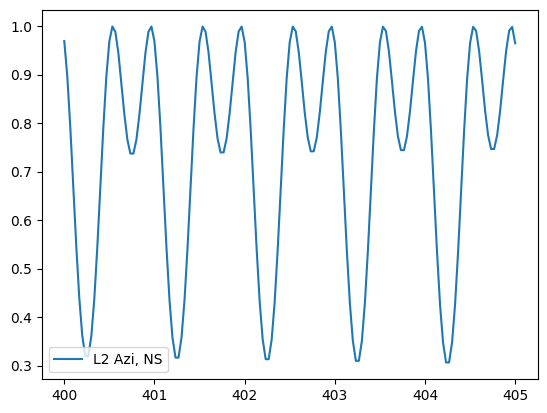

In [10]:
l2s = []
test_loss = get_polarization_loss(r_vt_interp, whip_vt_aligned, 0)

l2s = np.array(l2s)
for i in l2s:
	i = c_s_vec_conversion(i)


#plt.plot(new_times, l2s[:,2], label='L2 Azi, EW')
l2s=[]
test_loss2 = get_polarization_loss(r_vt_interp, whip_vt_aligned, 1)
l2s = np.array(l2s)
for i in l2s:
	i = c_s_vec_conversion(i)

plt.plot(new_times, l2s[:,2], label='L2 Azi, NS')
plt.legend()

### Receiver Gain Functions

In [9]:
from scipy.interpolate import RBFInterpolator as rbf
import pandas as pd
#documentation for interpolator - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html#scipy.interpolate.RBFInterpolator
# Get NEC data from excel spreadsheet
def data_from_excel(sheet_name):
	signal_data = pd.read_excel(sheet_name)
	# convert angle scales to match traj data
	signal_data['THETA']=signal_data['THETA'].abs()
	# convert complete loss value to avoid screwing up the interpolation
	signal_data.loc[signal_data['TOTAL']<=-900, 'TOTAL']=-20
	return(signal_data)

# Get interpolated function with Radial Basis Function 
def rbf_nec_data(signal_data):
	theta_vals = signal_data[['THETA']].to_numpy().flatten()
	phi_vals = signal_data[['PHI']].to_numpy().flatten()
	totals = signal_data['TOTAL'].to_numpy()
	interp = rbf(list(zip(theta_vals, phi_vals)), totals)
	return lambda thet, ph: interp(np.array([[thet, ph]])).item()
#interpolate trajectory data

def get_receiver_gain(signal_data, r_rocket):
	# interpolate function from NEC data
	rbf_f = rbf_nec_data(signal_data)
	# gain calculations
	gains = []
	for phi, theta in zip(r_rocket[:,2], r_rocket[:,1]):
		gains.append(rbf_f(theta, phi))
	return gains

def get_gain_contour(gain_func):
	X = np.linspace(0, 90, 100)
	Y = np.linspace(0, 360, 100)
	X, Y = np.meshgrid(X, Y)
	Z2 = np.array([gain_func(thet, ph) for thet, ph in zip(X.ravel(), Y.ravel())])
	Z2 = Z2.reshape(X.shape)
	plt.contourf(X, Y, Z2)
	plt.colorbar()
	plt.xlabel('Elevation Angle (degrees)')
	plt.ylabel('Azimuthal Angle (degrees)')
	plt.title('Receiver Gain')
	plt.show()


### Receiver Gain Calculation

In [10]:
nec_data = data_from_excel('10152024_nec_data.xlsx')
vt_rbf = get_receiver_gain(nec_data, r_vt_interp)
pf_rbf = get_receiver_gain(nec_data, r_pf_interp)
tl_rbf = get_receiver_gain(nec_data, r_tl_interp)

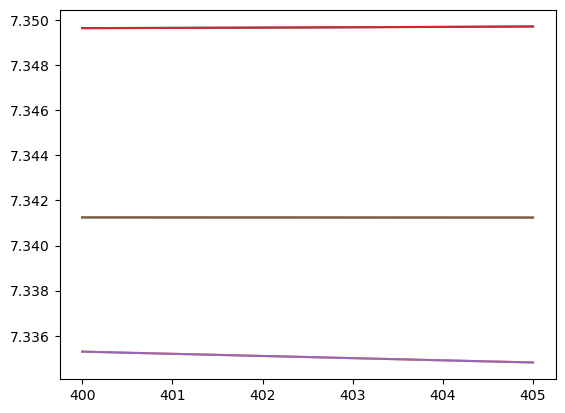

In [12]:
plt.plot(new_times, vt_rbf, label='VT')
plt.plot(new_times, pf_rbf, label='PF')
plt.plot(new_times, tl_rbf, label='TL')
plt.show()

### Signal Strength Calculator

In [13]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

def calc_received_power(radii, gains, ploss):
	result = []
	for radius, gain, pol_loss in zip(radii, gains, ploss):
		txPwr = 1.5  

		# Path loss calculation
		Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

		# Received power calculation in Watts

		Pwr_rx = (txPwr * Gtx * gain*(pol_loss**2)) / Lpath
		if Pwr_rx <= 0:
			Pwr_rx = 1e-100
		Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
		# Append the calculated power to the list, converting to dbm
		result.append(Pwr_rx_dBW+30)
	return result

def get_ratios(ew, ns, min_dbm=-200):
	ratio_list = []
	for i, j in zip(ew,ns):
		i_clamped = max(i,min_dbm)
		j_clamped = max(j,min_dbm)
		pmw_ew = 10**(i_clamped/10)
		pmw_ns = 10**(j_clamped/10)
		ratio = pmw_ew/pmw_ns
		ratio_dbm = 10*np.log10(ratio)
		ratio_list.append(ratio_dbm)
	return ratio_list

color_list = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 
				'magenta', 'yellow', 'black', 'lime', 'teal', 'navy', 'maroon', 'aqua', 'fuchsia', 'gold']
def plot_received_power_cross_dipole(times, power_list_ew, power_list_ns, power_labels, t_start=0, t_end = times[-1]):
	indices = np.where((times >= t_start) & (times <= t_end))[0]
	for i, power in enumerate(power_list_ew):
		plt.plot(times[indices], np.array(power)[indices], color=color_list[i % len(color_list)], label=power_labels[i])
	plt.legend(power_labels)
	plt.xlabel('Time (s)')
	plt.ylabel('Received Power (dBm)')
	plt.title('Received Power, EW Antenna')
	plt.ylim(-200, -50)
	plt.show()
	for i, power in enumerate(power_list_ns):
		plt.plot(times[indices], np.array(power)[indices], color=color_list[i % len(color_list)], label=power_labels[i])
	plt.legend(power_labels)
	plt.xlabel('Time (s)')
	plt.ylabel('Received Power (dBm)')
	plt.title('Received Power, NS Antenna')
	plt.ylim(-200, -50)
	plt.show()
	ratios = []
	for i, j in zip(power_list_ew, power_list_ns):
		ratios.append(get_ratios(np.array(i)[indices], np.array(j)[indices]))
	for i, ratio in enumerate(ratios):
		plt.plot(times[indices], ratio, color=color_list[i % len(color_list)], label=power_labels[i])
	plt.legend(power_labels)
	plt.xlabel('Time (s)')
	plt.ylabel('Power Difference (dB)')
	plt.title('Cross Dipole Power Difference')
	plt.ylim(-200, 200)
	plt.show()

def plot_received_power_dipole(times, power_list, power_labels, t_start=start_time, t_end = end_time):
	indices = np.where((times >= t_start) & (times <= t_end))[0]
	for i, power in enumerate(power_list):
		plt.plot(times[indices], np.array(power)[indices], color=color_list[i % len(color_list)], label=power_labels[i])
	plt.legend(power_labels)
	plt.xlabel('Time (s)')
	plt.ylabel('Received Power (dBm)')
	plt.title('Received Power')
	plt.ylim(-200, -50)
	plt.show()

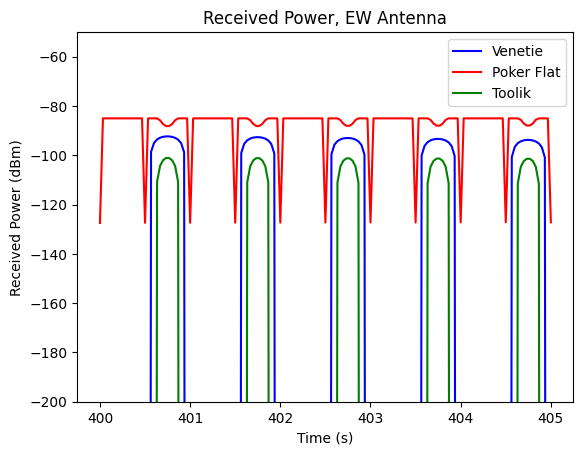

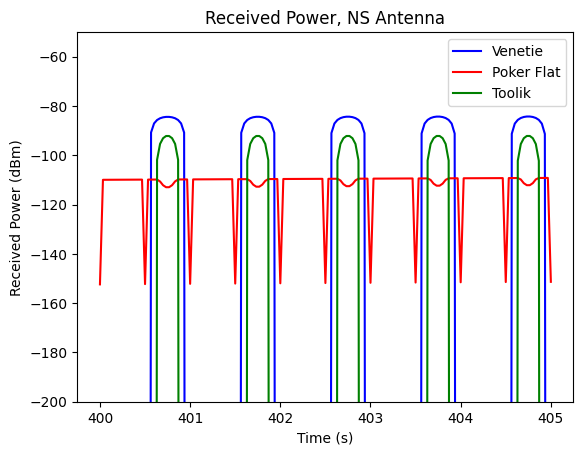

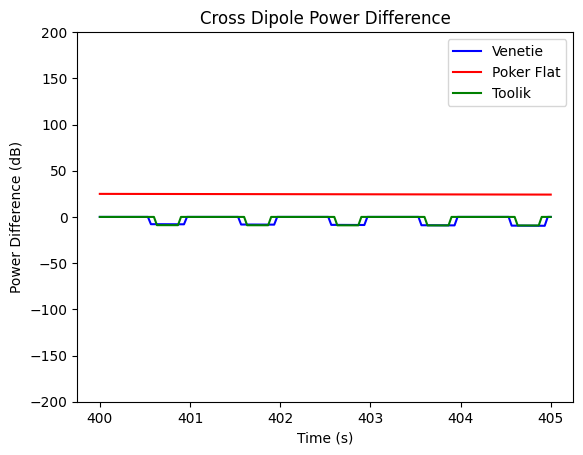

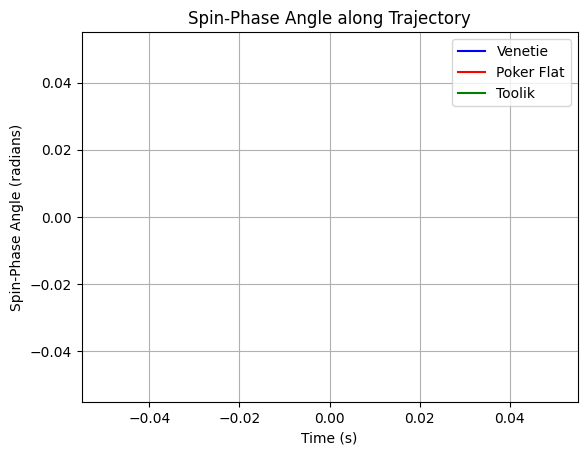

In [14]:
ew_powers = []
ew_powers.append(calc_received_power(r_vt_interp[:,0], vt_rbf, vt_pol_loss_EW))
ew_powers.append(calc_received_power(r_pf_interp[:,0], pf_rbf, pf_pol_loss_EW))
ew_powers.append(calc_received_power(r_tl_interp[:,0], tl_rbf, tl_pol_loss_EW))
ns_powers = []
ns_powers.append(calc_received_power(r_vt_interp[:,0], vt_rbf, vt_pol_loss_NS))
ns_powers.append(calc_received_power(r_pf_interp[:,0], pf_rbf, pf_pol_loss_NS))
ns_powers.append(calc_received_power(r_tl_interp[:,0], tl_rbf, tl_pol_loss_NS))
receiver_labels = ['Venetie', 'Poker Flat', 'Toolik']

plot_received_power_cross_dipole(new_times, ew_powers, ns_powers, receiver_labels)
# Calculate the spin-phase angle
indices = np.where((new_times >= 200) & (new_times <= 205))[0]
spin_phase_angle_vt = np.atan2(np.array(ns_powers[0])[indices], np.array(ew_powers[0])[indices])
spin_phase_angle_pf = np.atan2(np.array(ns_powers[1])[indices], np.array(ew_powers[1])[indices])
spin_phase_angle_tl = np.atan2(np.array(ns_powers[2])[indices], np.array(ew_powers[2])[indices])
# Plot the spin-phase angle
plt.plot(new_times[indices], spin_phase_angle_vt, color='blue')
plt.plot(new_times[indices], spin_phase_angle_pf, color='red')
plt.plot(new_times[indices], spin_phase_angle_tl, color='green')

plt.title("Spin-Phase Angle along Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Spin-Phase Angle (radians)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)
plt.show()

### Signal Plots

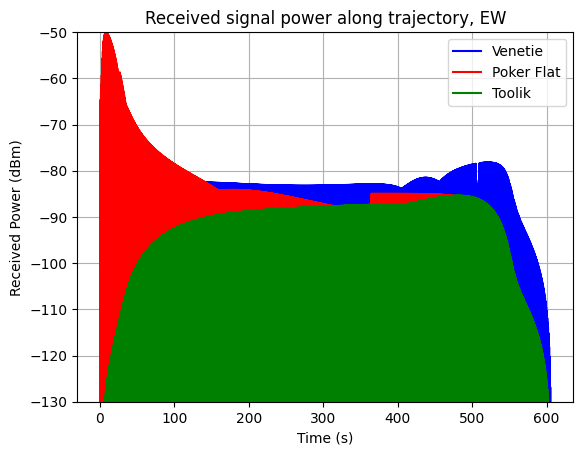

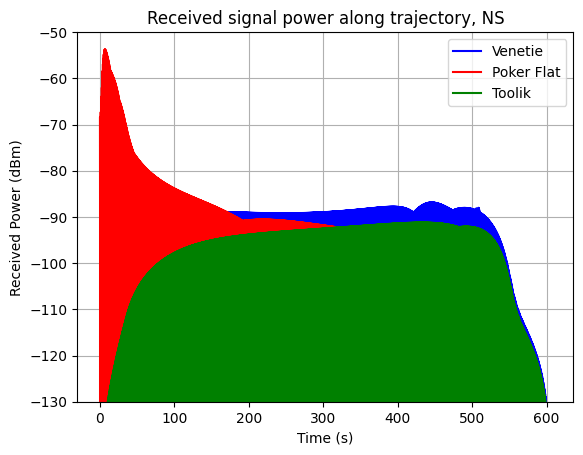

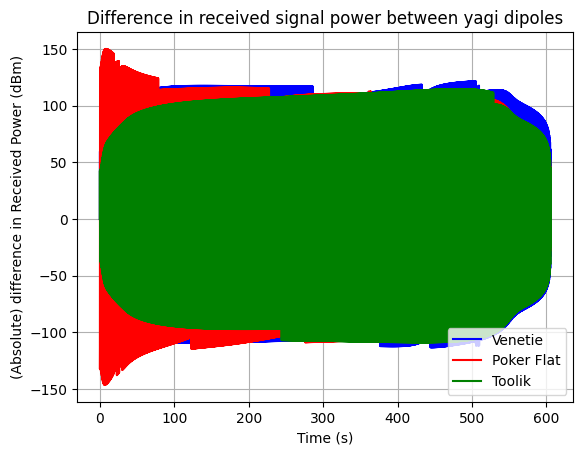

In [283]:
receivedpowervt_EW = calc_received_power(r_vt_interp[:,0], vt_rbf, vt_pol_loss_EW)
receivedpowerpf_EW = calc_received_power(r_pf_interp[:,0], pf_rbf, pf_pol_loss_EW)
receivedpowertl_EW = calc_received_power(r_tl_interp[:,0], tl_rbf, tl_pol_loss_EW)
receivedpowervt_NS = calc_received_power(r_vt_interp[:,0], vt_rbf, vt_pol_loss_NS)
receivedpowerpf_NS = calc_received_power(r_pf_interp[:,0], pf_rbf, pf_pol_loss_NS)
receivedpowertl_NS = calc_received_power(r_tl_interp[:,0], tl_rbf, tl_pol_loss_NS)

#plot EW antenna signal
plt.plot(new_times, receivedpowervt_EW, color='blue')
plt.plot(new_times, receivedpowerpf_EW, color='red')
plt.plot(new_times, receivedpowertl_EW, color='green')


plt.title("Received signal power along trajectory, EW")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True) 
plt.show()


#plot NS antenna signal
plt.plot(new_times, receivedpowervt_NS, color='blue')
plt.plot(new_times, receivedpowerpf_NS, color='red')
plt.plot(new_times, receivedpowertl_NS, color='green')

plt.title("Received signal power along trajectory, NS")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True)
plt.show()

# Plot signal difference
#takes two lists of powers in dbm
def get_ratios(ew, ns, min_dbm=-200):
	ratio_list = []
	for i, j in zip(ew,ns):
		i_clamped = max(i,min_dbm)
		j_clamped = max(j,min_dbm)
		pmw_ew = 10**(i_clamped/10)
		pmw_ns = 10**(j_clamped/10)
		ratio = pmw_ew/pmw_ns
		ratio_dbm = 10*np.log10(ratio)
		ratio_list.append(ratio_dbm)
	return ratio_list

signal_diff_vt = get_ratios(receivedpowervt_EW, receivedpowervt_NS)
signal_diff_pf = get_ratios(receivedpowerpf_EW, receivedpowerpf_NS)
signal_diff_tl = get_ratios(receivedpowertl_EW, receivedpowertl_NS)

plt.plot(new_times, signal_diff_vt, color='blue')
plt.plot(new_times, signal_diff_pf, color='red')
plt.plot(new_times, signal_diff_tl, color='green')

plt.title("Difference in received signal power between yagi dipoles")
plt.xlabel("Time (s)")
plt.ylabel("(Absolute) difference in Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)
plt.show()

Average sample rate: 10.00 Hz


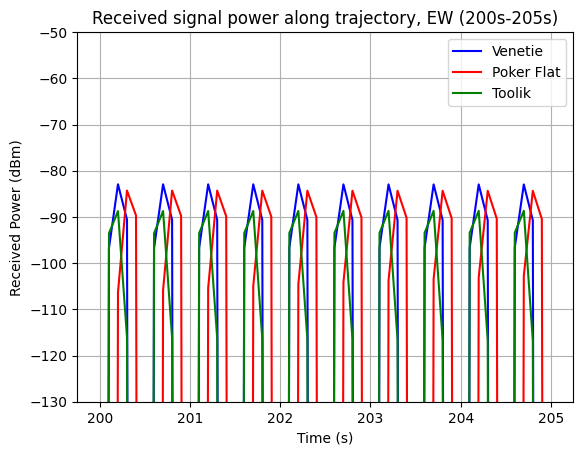

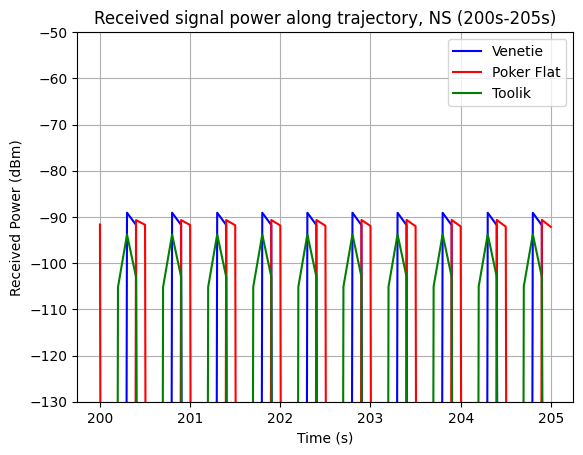

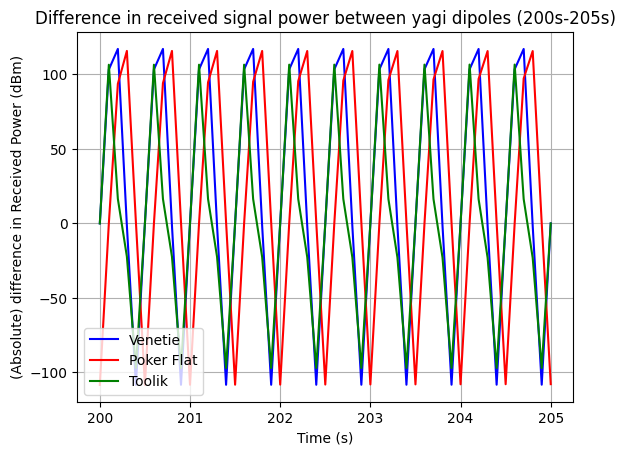

In [273]:
# Ensure all arrays are NumPy arrays
times_np = np.array(times)
radiivt = np.array(radiivt)
vt_rbf = np.array(vt_rbf)
vt_pol_loss_EW = np.array(vt_pol_loss_EW)
radiipf = np.array(radiipf)
pf_rbf = np.array(pf_rbf)
pf_pol_loss_EW = np.array(pf_pol_loss_EW)
radiitl = np.array(radiitl)
tl_rbf = np.array(tl_rbf)
tl_pol_loss_EW = np.array(tl_pol_loss_EW)
vt_pol_loss_NS = np.array(vt_pol_loss_NS)
pf_pol_loss_NS = np.array(pf_pol_loss_NS)
tl_pol_loss_NS = np.array(tl_pol_loss_NS)

# Define the time range
t_start = 200
t_end = 205

# Find the indices corresponding to the time range
indices = np.where((new_times >= t_start) & (new_times <= t_end))[0]

# Calculate received power for the specified time range
receivedpowervt_EW = calc_received_power(r_vt_interp[indices,0], vt_rbf[indices], vt_pol_loss_EW[indices])
receivedpowerpf_EW = calc_received_power(r_pf_interp[indices,0], pf_rbf[indices], pf_pol_loss_EW[indices])
receivedpowertl_EW = calc_received_power(r_tl_interp[indices,0], tl_rbf[indices], tl_pol_loss_EW[indices])

receivedpowervt_NS = calc_received_power(r_vt_interp[indices,0], vt_rbf[indices], vt_pol_loss_NS[indices])
receivedpowerpf_NS = calc_received_power(r_pf_interp[indices,0], pf_rbf[indices], pf_pol_loss_NS[indices])
receivedpowertl_NS = calc_received_power(r_tl_interp[indices,0], tl_rbf[indices], tl_pol_loss_NS[indices])

# Calculate and print the average sample rate
time_diff = np.diff(new_times[indices])
avg_sample_rate = 1 / np.mean(time_diff)  # Samples per second
print(f"Average sample rate: {avg_sample_rate:.2f} Hz")

# Plot EW antenna signal
plt.plot(new_times[indices], receivedpowervt_EW, color='blue')
plt.plot(new_times[indices], receivedpowerpf_EW, color='red')
plt.plot(new_times[indices], receivedpowertl_EW, color='green')

plt.title("Received signal power along trajectory, EW (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True)
plt.show()

# Plot NS antenna signal
plt.plot(new_times[indices], receivedpowervt_NS, color='blue')
plt.plot(new_times[indices], receivedpowerpf_NS, color='red')
plt.plot(new_times[indices], receivedpowertl_NS, color='green')

plt.title("Received signal power along trajectory, NS (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True)
plt.show()

signal_diff_vt = get_ratios(receivedpowervt_EW, receivedpowervt_NS)
signal_diff_pf = get_ratios(receivedpowerpf_EW, receivedpowerpf_NS)
signal_diff_tl = get_ratios(receivedpowertl_EW, receivedpowertl_NS)
plt.plot(new_times[indices], signal_diff_vt, color='blue')
plt.plot(new_times[indices], signal_diff_pf, color='red')
plt.plot(new_times[indices], signal_diff_tl, color='green')

plt.title("Difference in received signal power between yagi dipoles (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("(Absolute) difference in Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)
plt.show()

Average sample rate: 0.20 Hz


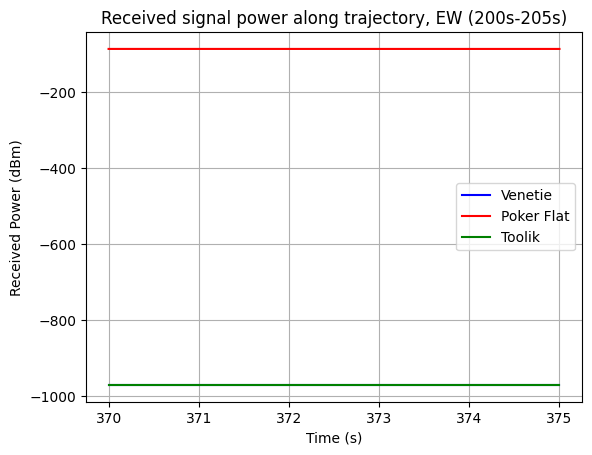

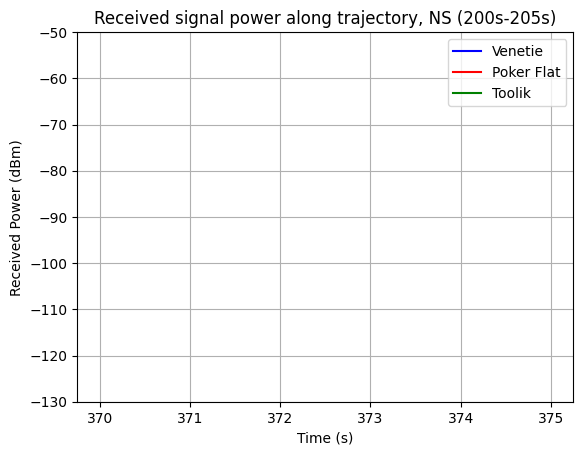

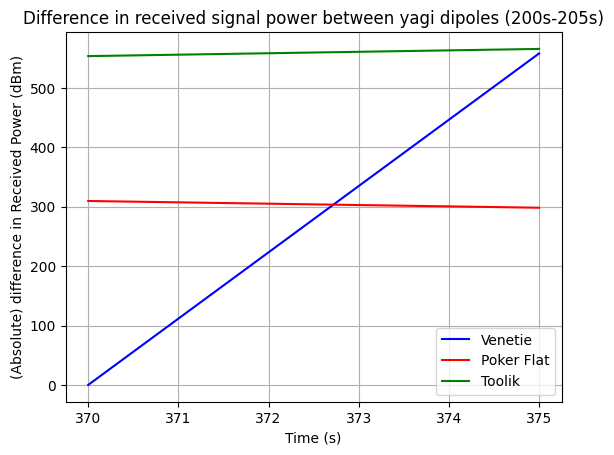

In [238]:
# Ensure all arrays are NumPy arrays
times_np = np.array(times)
radiivt = np.array(radiivt)
vt_rbf = np.array(vt_rbf)
vt_pol_loss_EW = np.array(vt_pol_loss_EW)
radiipf = np.array(radiipf)
pf_rbf = np.array(pf_rbf)
pf_pol_loss_EW = np.array(pf_pol_loss_EW)
radiitl = np.array(radiitl)
tl_rbf = np.array(tl_rbf)
tl_pol_loss_EW = np.array(tl_pol_loss_EW)
vt_pol_loss_NS = np.array(vt_pol_loss_NS)
pf_pol_loss_NS = np.array(pf_pol_loss_NS)
tl_pol_loss_NS = np.array(tl_pol_loss_NS)

# Define the time range
t_start = 370
t_end = 375

# Find the indices corresponding to the time range
indices = np.where((times_np >= t_start) & (times_np <= t_end))[0]

# Calculate received power for the specified time range
receivedpowervt_EW = calc_received_power(radiivt[indices], vt_rbf[indices], vt_pol_loss_EW[indices])
receivedpowerpf_EW = calc_received_power(radiipf[indices], pf_rbf[indices], pf_pol_loss_EW[indices])
receivedpowertl_EW = calc_received_power(radiitl[indices], tl_rbf[indices], tl_pol_loss_EW[indices])

receivvedpowervt_NS = calc_received_power(radiivt[indices], vt_rbf[indices], vt_pol_loss_NS[indices])
receivedpowerpf_NS = calc_received_power(radiipf[indices], pf_rbf[indices], pf_pol_loss_NS[indices])
receivedpowertl_NS = calc_received_power(radiitl[indices], tl_rbf[indices], tl_pol_loss_NS[indices])

# Calculate and print the average sample rate
time_diff = np.diff(times_np[indices])
avg_sample_rate = 1 / np.mean(time_diff)  # Samples per second
print(f"Average sample rate: {avg_sample_rate:.2f} Hz")

# Plot EW antenna signal
plt.plot(times_np[indices], receivedpowervt_EW, color='blue')
plt.plot(times_np[indices], receivedpowerpf_EW, color='red')
plt.plot(times_np[indices], receivedpowertl_EW, color='green')

plt.title("Received signal power along trajectory, EW (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
##plt.ylim(-130, -50)
plt.grid(True)
plt.show()

# Plot NS antenna signal
plt.plot(times_np[indices], receivvedpowervt_NS, color='blue')
plt.plot(times_np[indices], receivedpowerpf_NS, color='red')
plt.plot(times_np[indices], receivedpowertl_NS, color='green')

plt.title("Received signal power along trajectory, NS (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True)
plt.show()

# Plot signal difference
signal_diff_vt = np.abs(np.subtract(receivedpowervt_EW, receivvedpowervt_NS))
signal_diff_pf = np.abs(np.subtract(receivedpowerpf_EW, receivedpowerpf_NS))
signal_diff_tl = np.abs(np.subtract(receivedpowertl_EW, receivedpowertl_NS))

plt.plot(times_np[indices], signal_diff_vt, color='blue')
plt.plot(times_np[indices], signal_diff_pf, color='red')
plt.plot(times_np[indices], signal_diff_tl, color='green')

plt.title("Difference in received signal power between yagi dipoles (200s-205s)")
plt.xlabel("Time (s)")
plt.ylabel("(Absolute) difference in Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)
plt.show()


In [213]:
# Data
signif_vt = np.where(signal_diff_vt > 0.5)[0]
signif_pf = np.where(signal_diff_pf > 0.5)[0]
signif_tl = np.where(signal_diff_tl > 0.5)[0]
print(len(signif_vt)/len(signal_diff_vt))
print(len(signif_pf)/len(signal_diff_pf))
print(len(signif_tl)/len(signal_diff_tl))
print(times[len(times)-1])
t150=int(np.where(times_np==150)[0])
t500=int(np.where(times_np==500)[0])
clipped_signif_vt = np.where(signal_diff_vt[t150:t500] > 0.5)[0]
clipped_signif_pf = np.where(signal_diff_pf[t150:t500] > 0.5)[0]
clipped_signif_tl = np.where(signal_diff_tl[t150:t500] > 0.5)[0]
print("clipped")
print(len(clipped_signif_vt)/len(signal_diff_vt[t150:t500]))
print(len(clipped_signif_pf)/len(signal_diff_pf[t150:t500]))
print(len(clipped_signif_tl)/len(signal_diff_tl[t150:t500]))

0.4467584816929795
0.43903258313738663
0.39368491770238495
605.898
clipped
0.5121443442054129
0.5121443442054129
0.5218598195697433


C:\Users\skwal\AppData\Local\Temp\ipykernel_7516\641952199.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t150=int(np.where(times_np==150)[0])
C:\Users\skwal\AppData\Local\Temp\ipykernel_7516\641952199.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t500=int(np.where(times_np==500)[0])


# Reference/Archive

### Coordinate Plots

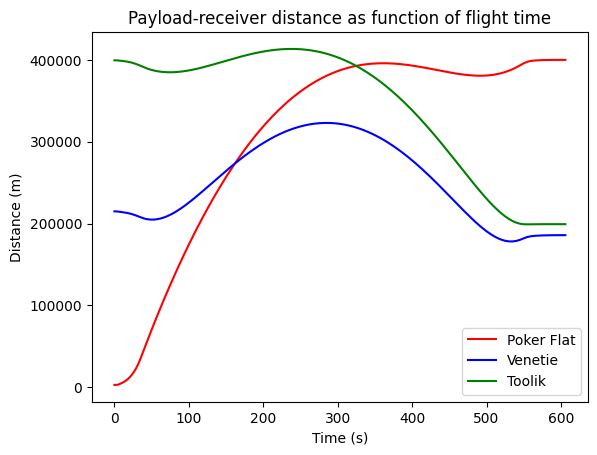

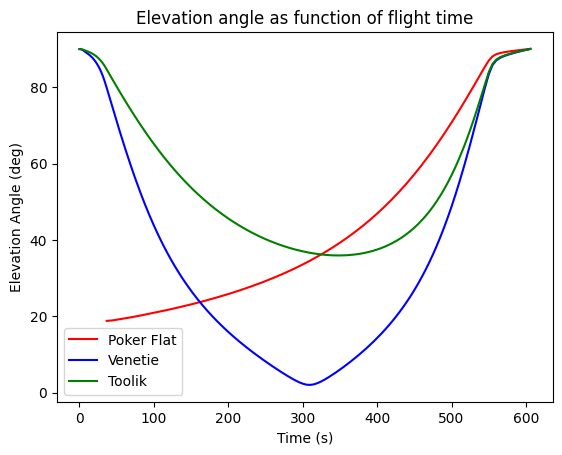

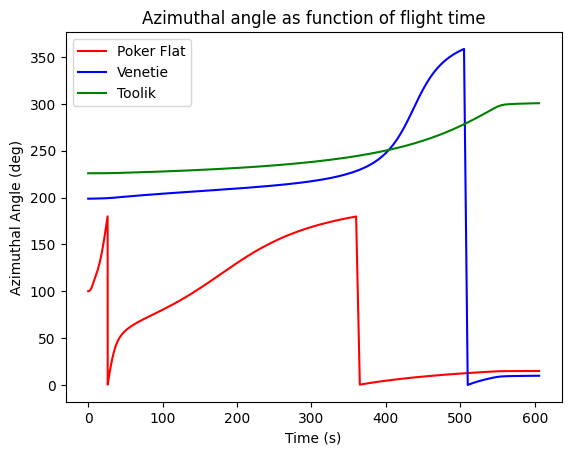

In [187]:
# Radius vs time
plt.plot(times, radiipf, label='Poker Flat', color='red')
plt.plot(times, radiivt, label='Venetie', color='blue')
plt.plot(times, radiitl, label='Toolik', color='green')
plt.title("Payload-receiver distance as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()
# Elevation angle vs time
plt.plot(times, fixed_thetaspf, label='Poker Flat', color='red')
plt.plot(times, thetasvt, label='Venetie', color='blue')
plt.plot(times, thetastl, label='Toolik', color='green')
plt.title("Elevation angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Elevation Angle (deg)")
plt.legend()
plt.show()
# Azimuthal angle vs time
plt.plot(times, phispf, label='Poker Flat', color='red')
plt.plot(times, phisvt, label='Venetie', color='blue')
plt.plot(times, phistl, label='Toolik', color='green')
plt.title("Azimuthal angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Azimuthal Angle (deg)")
plt.legend()
plt.show()


### Angular Dependence

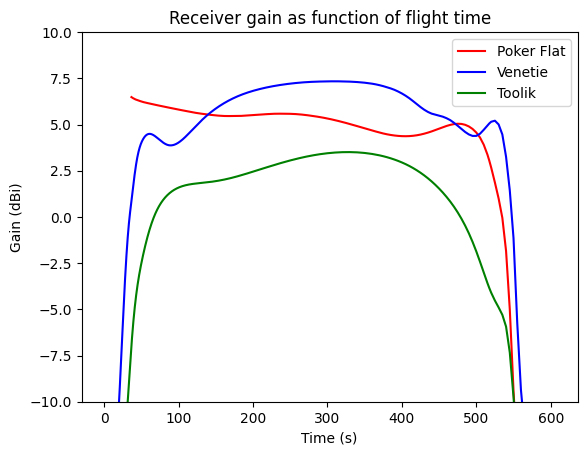

In [188]:
# Gain, angular dependence only
plt.plot(times, pf_rbf, label='Poker Flat', color='red')
plt.plot(times, vt_rbf, label='Venetie', color='blue')
plt.plot(times, tl_rbf, label='Toolik', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Gain (dBi)')
plt.ylim(-10,10)
plt.title('Receiver gain as function of flight time')
plt.legend()
plt.show()

### Radial Dependence

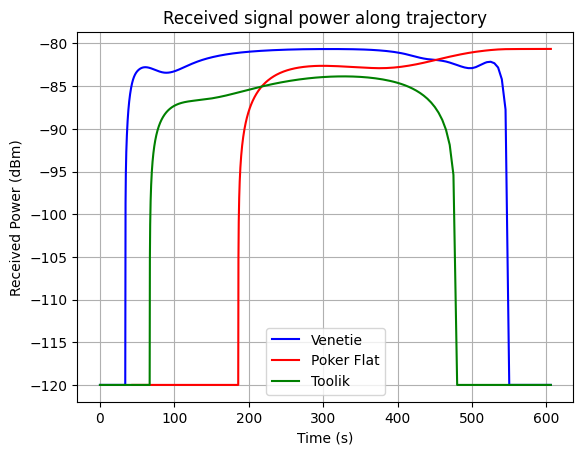

In [346]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant
r = 240000
receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm
receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)
#TEMP - remove signal jump at beginning of Poker Flat
# plot received power against trajectory
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

In [90]:
print(np.argmin(thetaspf))

373


### Radial and Angular Dependence

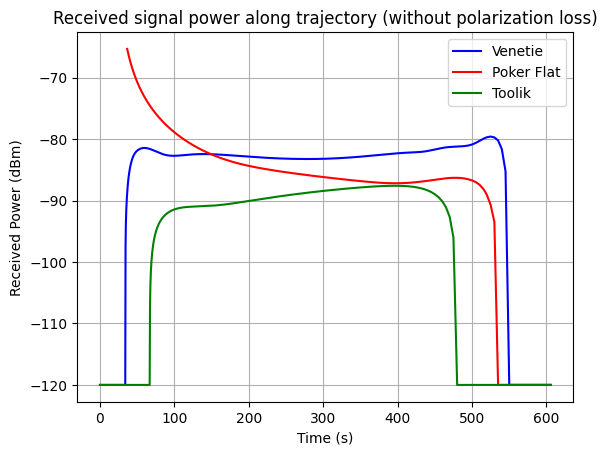

In [49]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)

#TEMP - remove signal jump at beginning of Poker Flat
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan

#plot received power along trajectory
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory (without polarization loss)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

### Height Comparisons

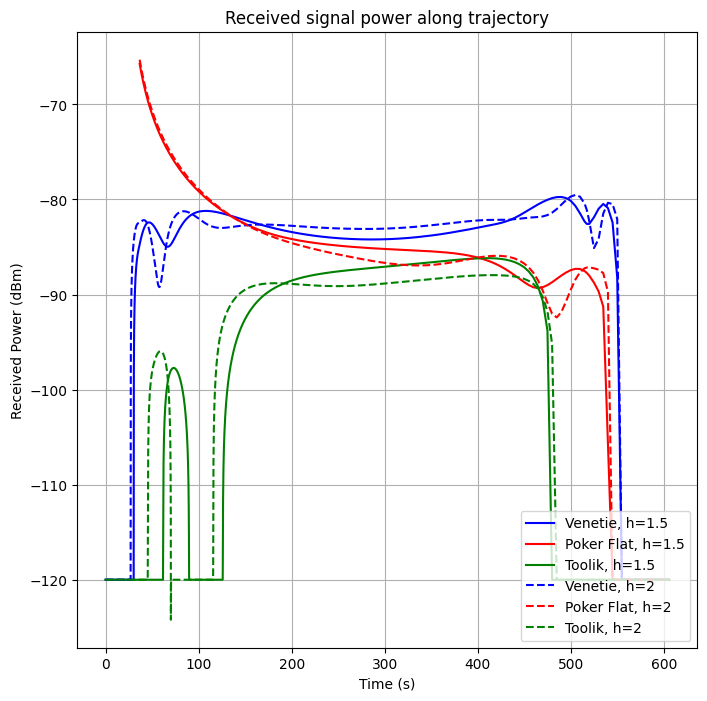

In [ ]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt = []
for radius, gain in zip(radiivt, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15pf = []
for radius, gain in zip(radiipf, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
for radius, gain in zip(radiitl, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)


#ht=2
ht2vt = []
for radius, gain in zip(radiivt, vt_ht2):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2pf = []
for radius, gain in zip(radiipf, pf_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2tl = []
for radius, gain in zip(radiitl, tl_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2tl.append(Pwr_rx_dBW+30)

plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht2vt, color='blue', linestyle='--')
plt.plot(times, ht2pf, color='red', linestyle='--')
plt.plot(times, ht2tl, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, h=1.5", "Poker Flat, h=1.5", "Toolik, h=1.5", "Venetie, h=2", "Poker Flat, h=2", "Toolik, h=2"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### NS Height Comparison

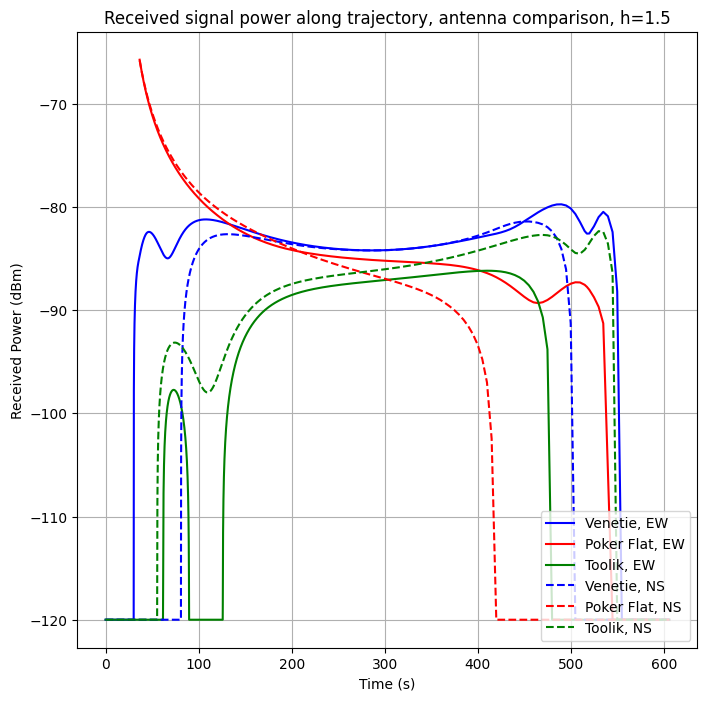

In [120]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)



plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht15vt_rotated, color='blue', linestyle='--')
plt.plot(times, ht15pf_rotated, color='red', linestyle='--')
plt.plot(times, ht15tl_rotated, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory, antenna comparison, h=1.5")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, EW", "Poker Flat, EW", "Toolik, EW", "Venetie, NS", "Poker Flat, NS", "Toolik, NS"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Antenna Difference

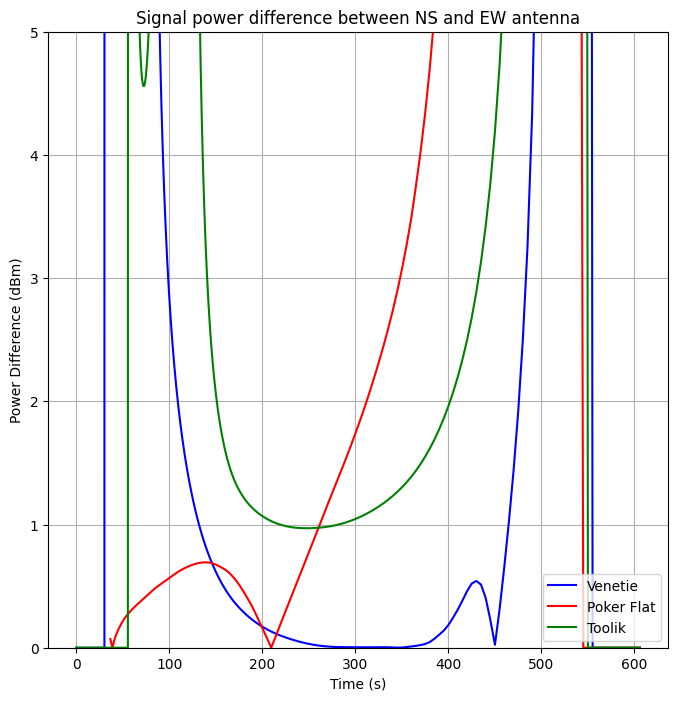

In [56]:
# Plotting difference between antenna orientations signal
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)


tldiff = []
pfdiff = []
vtdiff = []
for tl, pf, vt, tlrot, pfrot, vtrot in zip(ht15tl, ht15pf, ht15vt, ht15tl_rotated, ht15pf_rotated, ht15vt_rotated):
	tldiff.append(np.abs(tl-tlrot))
	pfdiff.append(np.abs(pf-pfrot))
	vtdiff.append(np.abs(vt-vtrot))
    
plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, vtdiff, color='blue')
plt.plot(times, pfdiff, color='red')
plt.plot(times, tldiff, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Signal power difference between NS and EW antenna")
plt.xlabel("Time (s)")
plt.ylabel("Power Difference (dBm)")
plt.ylim(0,5)
plt.legend(["Venetie", "Poker Flat", "Toolik"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Antenna Ratio

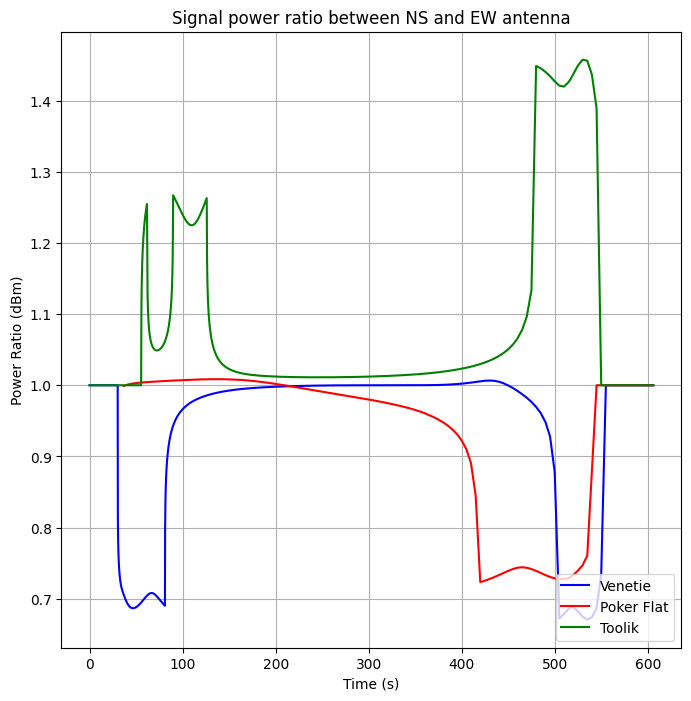

In [14]:
# Plotting ratio between antenna orientations signal
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)


tlratio = []
pfratio = []
vtratio = []
for tl, pf, vt, tlrot, pfrot, vtrot in zip(ht15tl, ht15pf, ht15vt, ht15tl_rotated, ht15pf_rotated, ht15vt_rotated):
	tlratio.append(np.abs(tl/tlrot))
	pfratio.append(np.abs(pf/pfrot))
	vtratio.append(np.abs(vt/vtrot))
    
plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, vtratio, color='blue')
plt.plot(times, pfratio, color='red')
plt.plot(times, tlratio, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Signal power ratio between NS and EW antenna")
plt.xlabel("Time (s)")
plt.ylabel("Power Ratio (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Adding Rocket Rotation

2.1
1.1


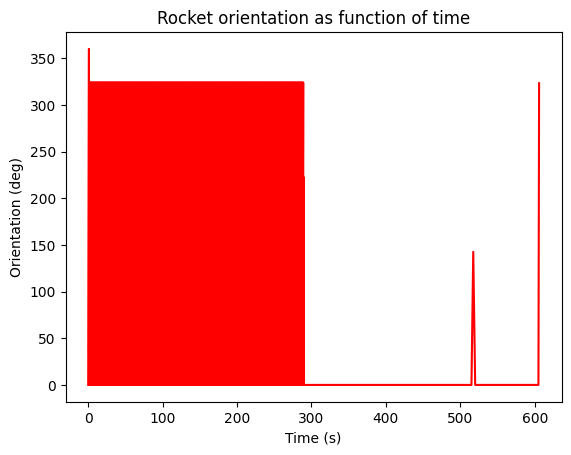

In [ ]:
def get_rocket_angles(frequency):
	first = True
	angvel = 360*frequency # deg/s
	rocketori = 0
	angles = []
	for i in range(len(times)):
		if times[i]*angvel>360:
			if first:
				print(times[i])
				first=False
			angles.append((times[i]*angvel)%360)
		else:
			rocketori = angvel*times[i]
			angles.append(rocketori)

	return angles

freq_rocket = 0.5 # Hz
rocket_angles_half = get_rocket_angles(0.5)
rocket_angles_one = get_rocket_angles(1)


plt.plot(times, rocket_angles_one, color='red')
#plt.scatter(times, rocket_angles_one, color='blue')
plt.title("Rocket orientation as function of time")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (deg)")
#plt.show()

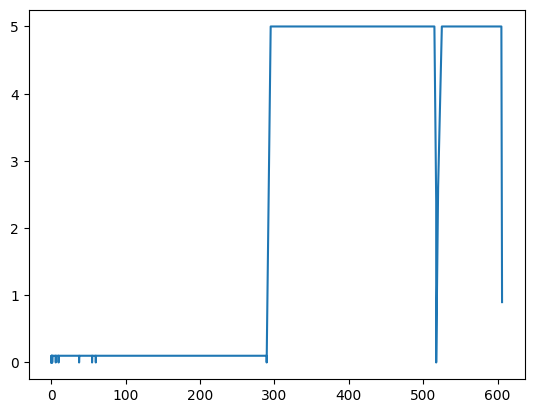

In [ ]:
#should just interpolate data out to like ten samples per spin
#note that the misalignment angle has to be a solid angle, where only one of the angles is spinning
timediffs = []
for i in range(len(times)-1):
	timediffs.append(times[i+1]-times[i])
timediffs.insert(0,0)
plt.plot(times, timediffs)

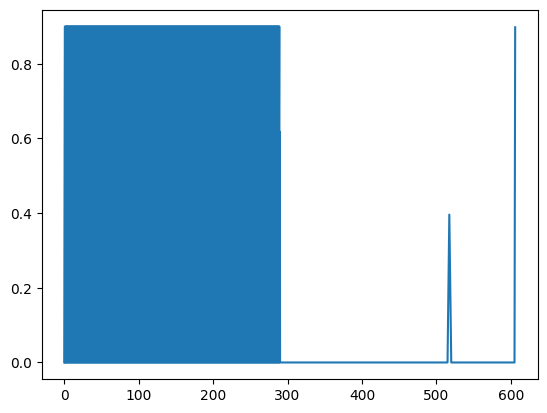

In [50]:
timedec = []
for i in range(len(times)):
	timedec.append(times[i]-np.floor(times[i]))
plt.plot(times, timedec)

[np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.622), np.float64(0.622), np.float64(0.7)]
[np.float64(565.0), np.float64(570.0), np.float64(575.0), np.float64(580.0), np.float64(585.0), np.float64(590.0), np.float64(595.0), np.float64(600.0), np.float64(605.0), np.float64(605.898)]


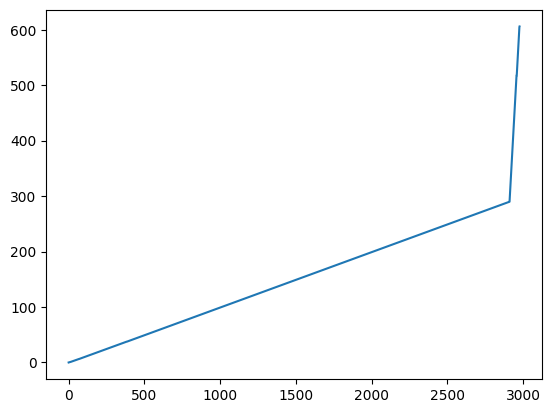

In [54]:
np.linspace(0,len(times),len(times))
plt.plot(np.linspace(0,len(times),len(times)), times)
print(times[0:10])
print(times[len(times)-10:len(times)])